In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers import LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [3]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [4]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [5]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [6]:
y = movie_reviews['sentiment']

y = array(list(map(lambda x: 1 if x=="positive" else 0, y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [8]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [9]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [10]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [11]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9254700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [12]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/6
250/250 [==============================] - 35s 133ms/step - loss: 0.5567 - acc: 0.7083 - val_loss: 0.4681 - val_acc: 0.7828
Epoch 2/6
250/250 [==============================] - 33s 131ms/step - loss: 0.4482 - acc: 0.7883 - val_loss: 0.4114 - val_acc: 0.8111
Epoch 3/6
250/250 [==============================] - 33s 132ms/step - loss: 0.4033 - acc: 0.8159 - val_loss: 0.3839 - val_acc: 0.8239
Epoch 4/6
250/250 [==============================] - 33s 133ms/step - loss: 0.3697 - acc: 0.8335 - val_loss: 0.3590 - val_acc: 0.8428
Epoch 5/6
250/250 [==============================] - 34s 136ms/step - loss: 0.3522 - acc: 0.8446 - val_loss: 0.3463 - val_acc: 0.8451
Epoch 6/6
313/313 [==============================] - 8s 25ms/step - loss: 0.3825 - acc: 0.8252
Test Score: 0.3824569582939148
Test Accuracy: 0.8252000212669373


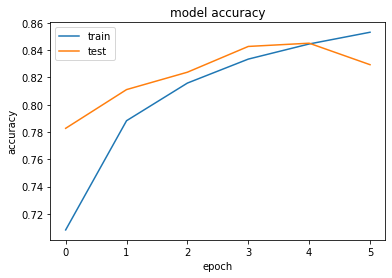

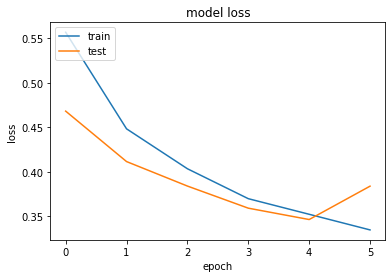

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [15]:
import numpy as np
sequence = tokenizer.texts_to_sequences(['this experience has been the worst , want my money back'])
test = pad_sequences(sequence, maxlen=maxlen)
predict = model.predict(test)
print(np.around(predict, decimals=3))

sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=maxlen)
predict = model.predict(test)
print(np.around(predict, decimals=3))
#sentiment[np.around(predict, decimals=0).argmax(axis=1)[0]]

[[0.342]]
[[0.769]]
